In [24]:
import os
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, make_scorer, log_loss, brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import warnings
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.calibration import CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
warnings.filterwarnings('ignore')

In [3]:
# Setup metrics (see: http://business-analytic.co.uk/blog/evaluating-expected-goals-models/)
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [4]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [5]:
# Load the data
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [6]:
# Split into train, calibration and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_penalty_train, X_penalty_test, y_penalty_train, y_penalty_test = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [7]:
# Load and split fake data
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.drop(['competition_gender','competition_gender','match_week'], axis=1, inplace=True)
df_fake.index = ['a'+str(idx) for idx in df_fake.index]

y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [8]:
# Add fake training data. I am not adding this to the test data as want this to be realistic of real data.
X_train = pd.concat([X_train, X_fake])
y_train = pd.concat([y_train, y_fake])

In [9]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train = clean_lightgbm(X_train)
X_test = clean_lightgbm(X_test)

In [10]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train = clean_lightgbm_p(X_penalty_train)
X_penalty_test = clean_lightgbm_p(X_penalty_test)

In [10]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [11]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [12]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.8938924197798791                                     
SCORE:                                                                            
0.8938924197798791                                                                
SCORE:                                                                            
0.8938924197798791                                                                
SCORE:                                                                            
0.8942799565958766                                                                
SCORE:                                                                            
0.8941249418694776                                                                
SCORE:                                                                            
0.8955200744070687                                                                
SCORE:                                                    

SCORE:                                                                             
0.8958301038598667                                                                 
SCORE:                                                                             
0.8938924197798791                                                                 
SCORE:                                                                             
0.8953650596806697                                                                 
SCORE:                                                                             
0.8955200744070687                                                                 
SCORE:                                                                             
0.8942799565958766                                                                 
SCORE:                                                                             
0.8938924197798791                                                          

0.8955975817702682                                                                 
SCORE:                                                                             
0.8952875523174701                                                                 
SCORE:                                                                             
0.8952875523174701                                                                 
100%|██████████| 100/100 [04:12<00:00,  2.52s/trial, best loss: -0.8959076112230662]


In [13]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.558729738467207, 'gamma': 7.947271005831234, 'max_depth': 3.0, 'min_child_weight': 1.0, 'reg_alpha': 42.0, 'reg_lambda': 0.10443753358579017}


In [25]:
# Fit the nested 5-fold cross validation using Bayesian optimisation.
xgb_cccv = CalibratedClassifierCV(XGBClassifier(random_state=42), method='isotonic', cv=3)
xgb_param_grid = {'base_estimator__min_child_samples': Integer(0, 200),
                   'base_estimator__num_leaves': Integer(2, 500),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 500)}
# Nested resampling using skopt. see: https://github.com/scikit-optimize/scikit-optimize/issues/725
xgb_np = BayesSearchCV(estimator=xgb_cccv,
                         n_iter=100,
                         search_spaces=xgb_param_grid,
                         cv=5,
                         n_jobs=-1)
xgb_np.fit(X_train, y_train)
# Nested resampling using skopt. see: https://github.com/scikit-optimize/scikit-optimize/issues/725
xgb_p = BayesSearchCV(estimator=xgb_cccv,
                         n_iter=100,
                         search_spaces=xgb_param_grid,
                         cv=5,
                         n_jobs=-1)
xgb_p.fit(X_penalty_train, y_penalty_train)

KeyboardInterrupt: 

In [11]:
xgb_np = XGBClassifier(objective='binary:logistic', alpha=10, n_estimators=100, eval_metric='logloss', learning_rate=0.05,
                       n_jobs=-1, max_depth=3)
xgb_np.fit(X_train, y_train)
xgb_p = XGBClassifier(objective='binary:logistic', max_depth=7, n_estimators=100, eval_metric='logloss',
                    learning_rate=0.05, n_jobs=-1)
xgb_p.fit(X_penalty_train, y_penalty_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [ ]:
# Permutation importance
# note not using fake data for permutation importance
perm_result = permutation_importance(xgb_np, X_train, y_train, n_repeats=10, random_state=42)
df_perm_importance = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])

In [14]:
# Permutation importance
# note not using fake data for permutation importance
perm_result_p = permutation_importance(xgb_p, X_penalty_train, y_penalty_train, n_repeats=10, random_state=42)
df_perm_importance_p = pd.DataFrame({'Feature':X_penalty_train.columns,
                                   'importance': perm_result_p.importances.mean(axis=1),
                                   'std_dev': perm_result_p.importances.std(axis=1)})
df_perm_importance_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_p.reset_index(drop=True, inplace=True)
df_perm_importance_p

,Feature,importance,std_dev
0,shot_number,0.078354,0.010093
1,match_moment,0.050152,0.008278
2,shot_player_number,0.041006,0.006190
3,competition_part,0.040549,0.005951
4,H_A_column,0.021494,0.003572
5,players_rival,0.017988,0.003033
6,players,0.005640,0.003412
7,competition_type,0.003354,0.001494


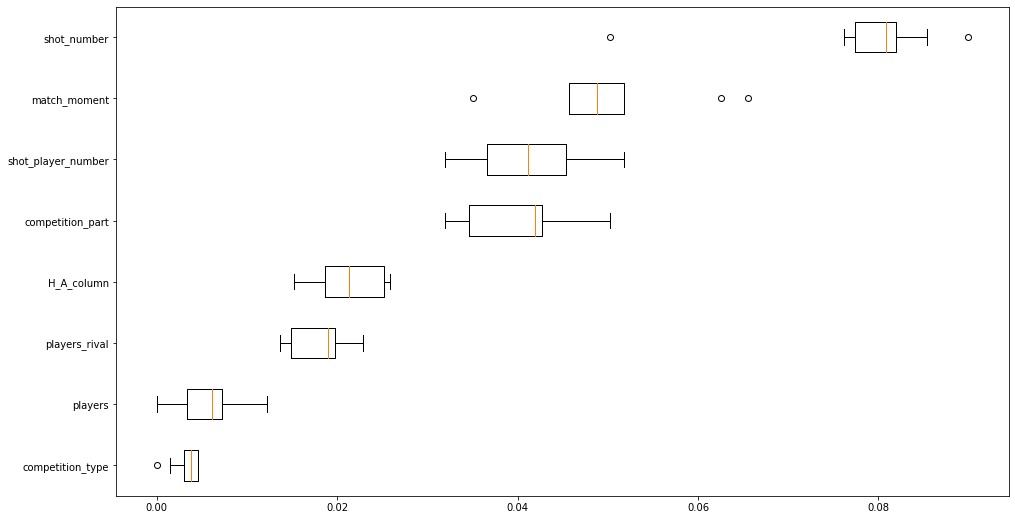

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train.columns[sorted_idx])

In [ ]:
# Calculate calibration curve on test data
y_pred_xgb_calibrated = xgb_np.predict_proba(X_test)
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_test, y_pred_xgb_calibrated[:, 1], n_bins=10)

In [ ]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_xgb_calibrated[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [ ]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, y_pred_xgb_calibrated)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, y_pred_xgb_calibrated[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_test, y_pred_xgb_calibrated[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_test, y_pred_xgb_calibrated[:,1], pos_label=y_test.max()))

In [30]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, y_pred_xgb_calibrated)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, y_pred_xgb_calibrated[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_test, y_pred_xgb_calibrated[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_test, y_pred_xgb_calibrated[:,1], pos_label=y_test.max()))

The log loss of the model with Random Search is: 0.28146274652807185
The ROC AUC score of the model with Random Search is: 0.7899906686291702
Pseudo R-squared, logistic regression: 0.16800622299073176
Brier score, logistic regression: 0.08152145576257959


In [29]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, y_pred_xgb_calibrated)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, y_pred_xgb_calibrated[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_test, y_pred_xgb_calibrated[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_test, y_pred_xgb_calibrated[:,1], pos_label=y_test.max()))

The log loss of the model with Random Search is: 0.28390375497329234
The ROC AUC score of the model with Random Search is: 0.7873022229791642
Pseudo R-squared, logistic regression: 0.160790689634711
Brier score, logistic regression: 0.08199303104887563


In [1]:
# Calculate calibration curve on test data
y_pred_xgb_calibrated_p = xgb_p.predict_proba(X_penalty_test)
fraction_of_positives_xgb_p, mean_predicted_value_xgb_p = calibration_curve(y_penalty_test, y_pred_xgb_calibrated_p[:, 1],
                                                                            n_bins=10)

NameError: name 'xgb_p' is not defined

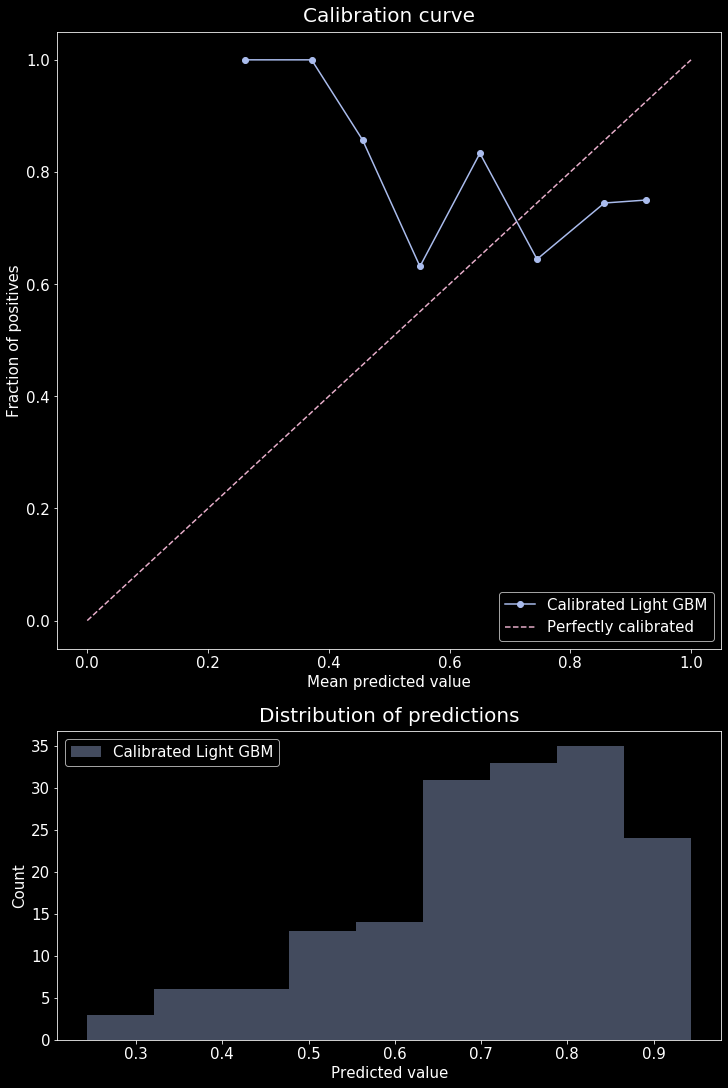

In [33]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_xgb_p, fraction_of_positives_xgb_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_xgb_calibrated_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [34]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_penalty_test, y_pred_xgb_calibrated_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_penalty_test, 
                                                                                  y_pred_xgb_calibrated_p[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_penalty_test, y_pred_xgb_calibrated_p[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_penalty_test, y_pred_xgb_calibrated_p[:,1], 
                                                           pos_label=y_penalty_test.max()))

The log loss of the model with Random Search is: 0.6706552405926314
The ROC AUC score of the model with Random Search is: 0.4412886008387343
Pseudo R-squared, logistic regression: -0.1690205108999443
Brier score, logistic regression: 0.2319049985412154
